# Testing the object insertion functions

In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import os
from tqdm import tqdm

## Guided anchoring

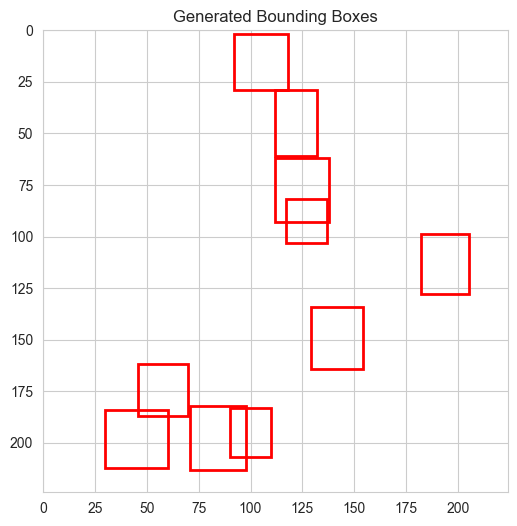

In [2]:
def generate_random_bboxes(num_boxes, max_size=224, min_box_size=20, max_box_size=32):
    """
    Generates a list of random bounding boxes within the given image size.

    Args:
        num_boxes (int): Number of bounding boxes to generate.
        max_size (int): The size of the image (e.g., 224 for a 224x224 image).
        min_box_size (int): Minimum width/height of a bounding box.
        max_box_size (int): Maximum width/height of a bounding box.

    Returns:
        List of bounding boxes: [[x_min, y_min, x_max, y_max], ...]
    """
    bboxes = []

    for _ in range(num_boxes):
        w = random.randint(min_box_size, max_box_size)
        h = random.randint(min_box_size, max_box_size)

        x_min = random.randint(0, max_size - w)
        y_min = random.randint(0, max_size - h)

        x_max = x_min + w
        y_max = y_min + h

        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes

test_bboxes = generate_random_bboxes(10)  # 10 random boxes within 224x224

def plot_bboxes(bboxes, img_size=224):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.set_xlim([0, img_size])
    ax.set_ylim([0, img_size])
    ax.set_title("Generated Bounding Boxes")
    ax.invert_yaxis()  # Optional: to match image coordinate system

    for box in bboxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.grid(True)
    plt.show()
plot_bboxes(test_bboxes)


In [8]:
def locate_anchor(dst_bbox):
    """
    Generates a new bounding box that is close to but does not overlap with the given bounding box.
    The new bounding box may have a different size.

    Args:
        src_bbox (list): [x_min, y_min, x_max, y_max] representing the original bounding box.
        min_distance (int): Minimum distance to move the new bounding box away.
        max_distance (int): Maximum distance to move the new bounding box away.
        size_variation (float): Maximum percentage by which the new box size can vary (e.g., 0.5 = ±50%).

    Returns:
        list: [x_min, y_min, x_max, y_max] for the new non-overlapping bounding box.
    """

    obj_size = (random.randint(1, 32), random.randint(1, 32))

    # Initialize minimum and maximum distance to move the new bounding box
    min_distance = 0.2 * obj_size[0]
    max_distance = 0.5 * obj_size[0]

    # Calculate scaling factors
    scale = 0.5

    # Extract destination bounding box information
    x_min, y_min, x_max, y_max = dst_bbox
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    for i in range(100):
        # Compute diagonal distances (to ensure proper separation)
        orig_diag = np.sqrt(width ** 2 + height ** 2) / 2

        # Choose a random angle (0 to 360 degrees)
        angle = random.uniform(0, 2 * np.pi)

        # Ensure the distance is at least greater than the diagonal
        min_safe_distance = orig_diag + min_distance
        max_safe_distance = orig_diag + max_distance
        distance = random.uniform(min_safe_distance, max_safe_distance)

        # First scale the center to target space
        center_x_scaled = center_x * scale
        center_y_scaled = center_y * scale

        # Then apply distance shift in target space
        new_center_x = center_x + distance * np.cos(angle)
        new_center_y = center_y + distance * np.sin(angle)

        # Compute new bounding box coordinates
        new_x_min = int(new_center_x - obj_size[0] / 2)
        new_y_min = int(new_center_y - obj_size[1] / 2)
        new_x_max = int(new_center_x + obj_size[0] / 2)
        new_y_max = int(new_center_y + obj_size[1] / 2)

        new_bbox = [new_x_min, new_y_min, new_x_max, new_y_max]

        if min(new_bbox) > 20 and max(new_bbox) < (224 - 20):
            final_bbox = new_bbox
            return final_bbox

    return None

for box in test_bboxes:
    anchor = locate_anchor(box)
    print(anchor, box)

[125, 172, 138, 180] [138, 171, 164, 191]
[49, 36, 72, 58] [22, 25, 44, 56]
[171, 69, 181, 77] [186, 57, 207, 81]
[133, 132, 141, 158] [142, 123, 164, 148]
[129, 149, 156, 167] [152, 123, 183, 150]
[85, 123, 107, 139] [109, 125, 138, 149]
[21, 187, 49, 188] [1, 182, 24, 210]
[141, 47, 164, 51] [169, 35, 195, 60]
[100, 74, 117, 90] [111, 93, 141, 117]
[169, 157, 187, 174] [145, 138, 169, 165]


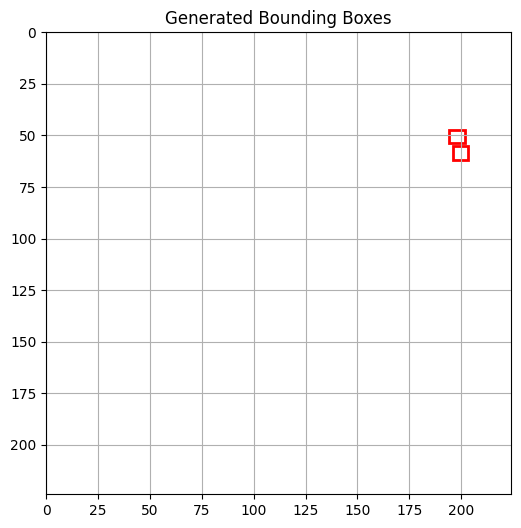

In [11]:
test_bboxes =[[194.25, 47.25, 201.6875, 53.8125], [196, 55, 203, 62]]
plot_bboxes(test_bboxes)

## Creating Masks

In [26]:
def create_mask(obj):
    gray_obj = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce the noise
    blur_obj = cv2.GaussianBlur(gray_obj, (3, 3), 0)

    # Auto threshold using Otsu's method
    _, binary = cv2.threshold(blur_obj, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    return clean

  0%|          | 0/4054 [00:00<?, ?it/s]

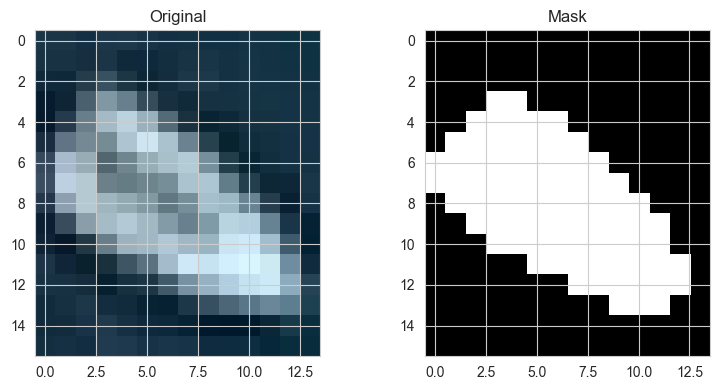

  0%|          | 1/4054 [00:00<18:11,  3.71it/s]

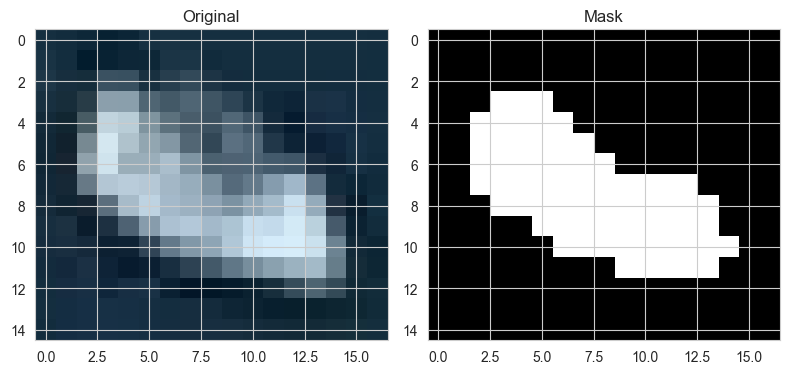

  0%|          | 2/4054 [00:00<25:31,  2.65it/s]

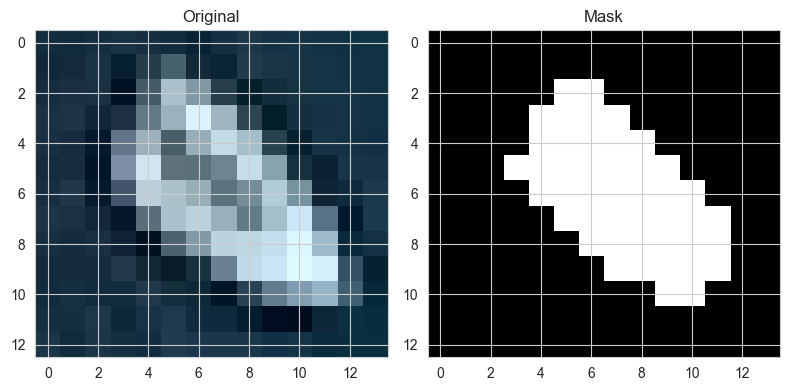

  0%|          | 3/4054 [00:01<23:58,  2.82it/s]

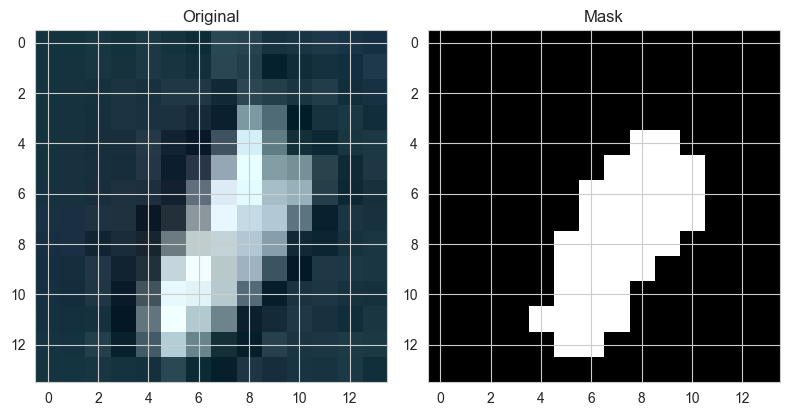

  0%|          | 4/4054 [00:01<21:14,  3.18it/s]

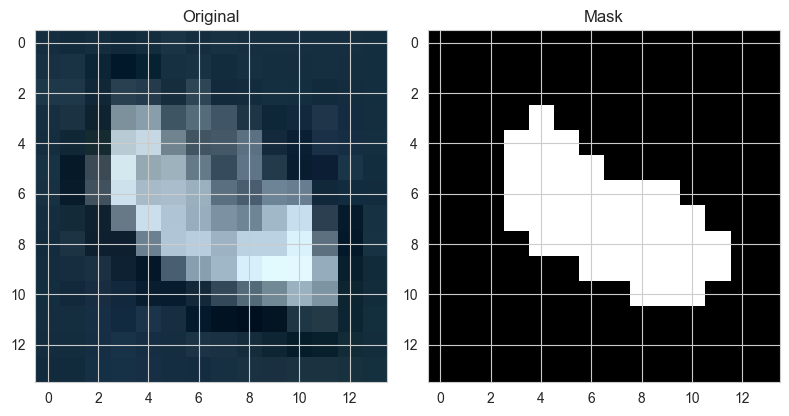

  0%|          | 5/4054 [00:01<20:49,  3.24it/s]

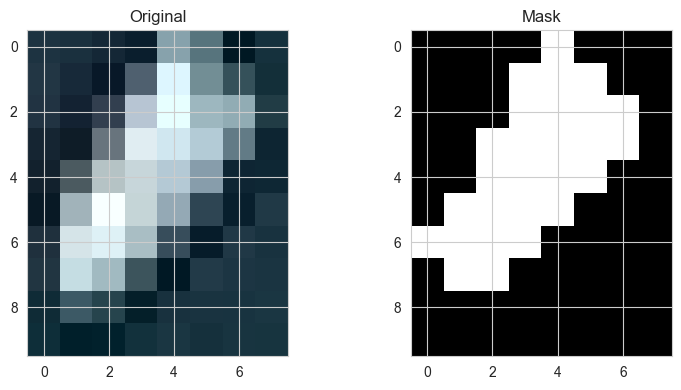

  0%|          | 6/4054 [00:01<18:44,  3.60it/s]

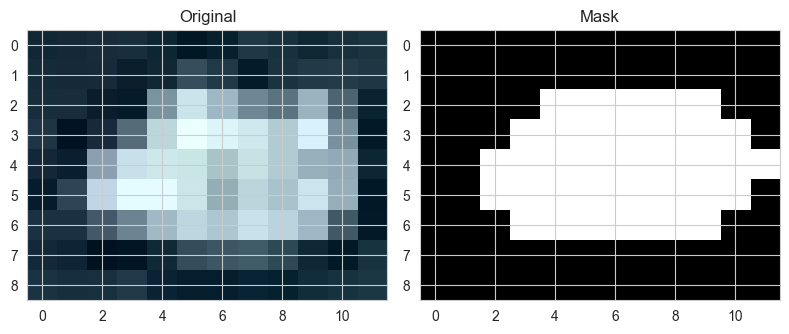

  0%|          | 7/4054 [00:02<18:31,  3.64it/s]

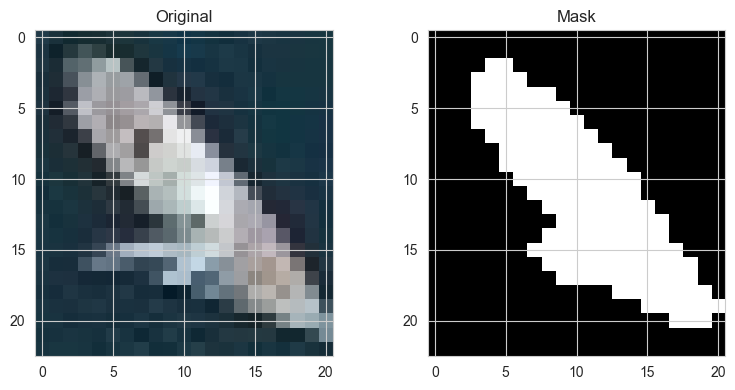

  0%|          | 8/4054 [00:02<17:23,  3.88it/s]

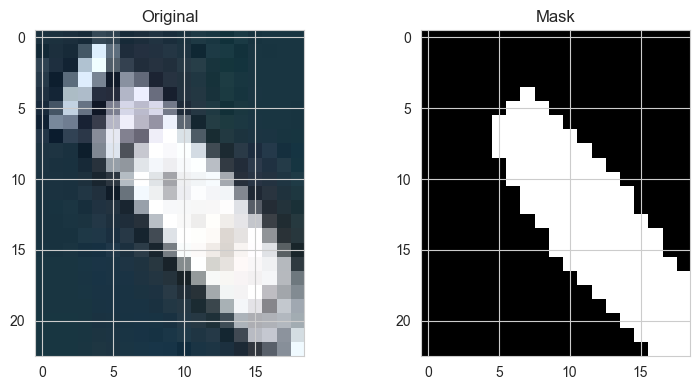

  0%|          | 9/4054 [00:02<17:00,  3.96it/s]

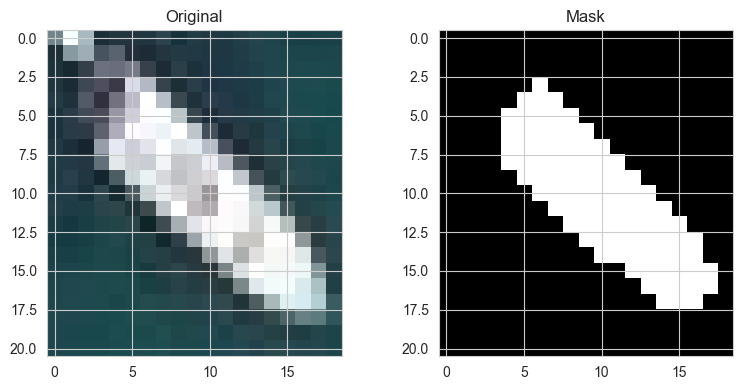

  0%|          | 10/4054 [00:02<17:00,  3.96it/s]

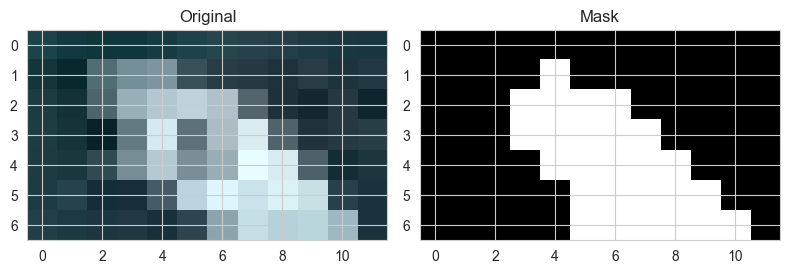

  0%|          | 11/4054 [00:03<18:54,  3.56it/s]


KeyboardInterrupt: 

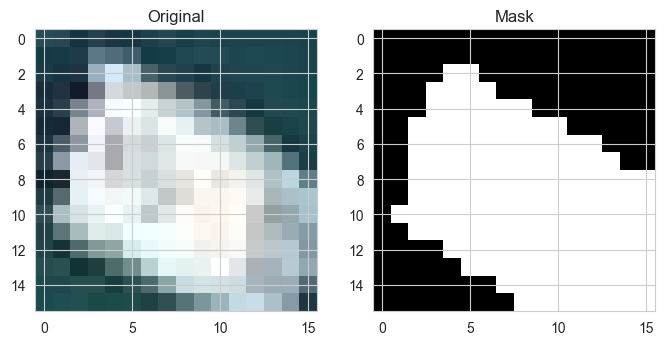

In [27]:
# Load image using OpenCV
path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/MasatiV2/MasatiV2Boats"
max_plots = 100
count = 0

for file in tqdm(os.listdir(path)):
    if count >= max_plots:
        break

    img_path = os.path.join(path, file)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    obj = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = create_mask(obj)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(obj)
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.tight_layout()
    plt.show()

    count += 1

In [28]:
dst_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/masati-thesis/images/s0012.png"
src_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/MasatiV2/MasatiV2Boats/m0128_boat1.png"

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        ndarray: Preprocessed image in BGR format
    """
    # Load image using OpenCV
    img = cv2.imread(image_path)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)

    return img

dst = load_and_preprocess_image(dst_path)
src = cv2.imread(src_path, cv2.IMREAD_COLOR)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src = np.array(cv2.resize(src, (24, 24), interpolation=cv2.INTER_LANCZOS4))

mask = create_mask(src)
center = (100, 80)

def insert_object_with_mask(src, dst, mask, center):
    """
    Inserts an object from `src` into `dst` using `mask` at a given `center`.
    Only pixels where the mask is non-zero are replaced.

    Args:
        src (H, W, 3): Source image containing the object.
        dst (H', W', 3): Destination (background) image.
        mask (H, W): Grayscale mask with object as white (255), background as black (0).
        center (x, y): Tuple indicating where the center of the object should go in dst.

    Returns:
        dst_copy: A new image with the object inserted.
    """
    src_h, src_w = src.shape[:2]
    dst_h, dst_w = dst.shape[:2]
    cx, cy = center

    # Calculate the top-left corner in dst where the src will go
    x1_dst = max(cx - src_w // 2, 0)
    y1_dst = max(cy - src_h // 2, 0)
    x2_dst = min(x1_dst + src_w, dst_w)
    y2_dst = min(y1_dst + src_h, dst_h)

    # Corresponding region in src and mask
    x1_src = max(0, -(cx - src_w // 2))
    y1_src = max(0, -(cy - src_h // 2))
    x2_src = x1_src + (x2_dst - x1_dst)
    y2_src = y1_src + (y2_dst - y1_dst)

    # Prepare output image
    dst_copy = dst.copy()

    # Crop the relevant parts
    src_crop = src[y1_src:y2_src, x1_src:x2_src]
    mask_crop = mask[y1_src:y2_src, x1_src:x2_src]
    roi = dst_copy[y1_dst:y2_dst, x1_dst:x2_dst]

    # Convert mask to boolean mask
    if len(mask_crop.shape) == 3:
        mask_crop = cv2.cvtColor(mask_crop, cv2.COLOR_BGR2GRAY)
    object_mask = mask_crop > 0

    # Replace pixels in dst only where mask is non-zero
    roi[object_mask] = src_crop[object_mask]
    dst_copy[y1_dst:y2_dst, x1_dst:x2_dst] = roi

    return dst_copy

copy = insert_object_with_mask(src, dst, mask, center)
print(copy)

[[[ 38  72  98]
  [ 72 103 128]
  [139 169 194]
  ...
  [ 22  50  95]
  [  5  44  88]
  [ 56  98 140]]

 [[104 139 161]
  [ 97 129 150]
  [ 10  35  59]
  ...
  [  8  41  95]
  [  3  38  85]
  [  3  42  82]]

 [[ 59  97 118]
  [111 144 167]
  [ 93 119 143]
  ...
  [ 21  56 106]
  [ 32  71 114]
  [ 42  85 120]]

 ...

 [[ 56  95 127]
  [ 24  61  90]
  [133 166 192]
  ...
  [ 75 120 145]
  [ 78 119 137]
  [ 38  77  99]]

 [[ 37  75 112]
  [ 21  58  93]
  [ 10  44  79]
  ...
  [ 12  57  88]
  [ 31  72 104]
  [ 79 119 153]]

 [[ 25  61  96]
  [ 74 112 147]
  [ 51  90 126]
  ...
  [ 22  67 105]
  [ 23  64 108]
  [ 28  71 111]]]


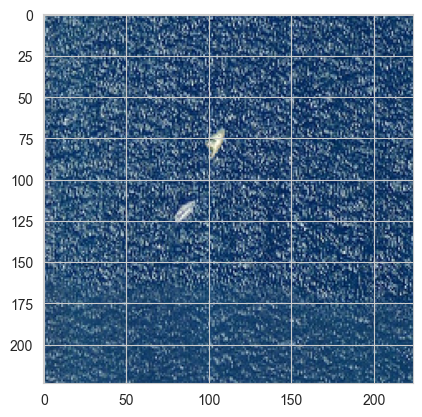

In [16]:
plt.imshow(copy)
plt.show()

## Paper Examples

### Bad Wake Masking

In [85]:
img_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/masati-thesis/images/x0043.png"
boat_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/MasatiV2/MasatiV2Boats/x0043_boat0.png"

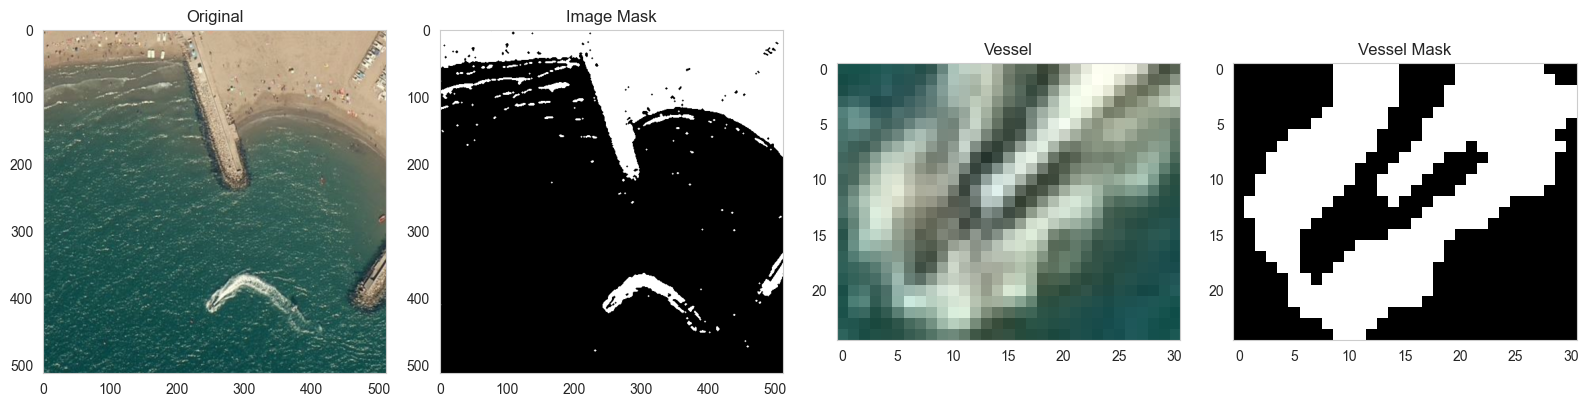

In [86]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mask = create_mask(img)

boat = cv2.imread(boat_path, cv2.IMREAD_COLOR)
obj = cv2.cvtColor(boat, cv2.COLOR_BGR2RGB)
boat_mask = create_mask(obj)

plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original')
plt.grid(False)

plt.subplot(1, 4, 2)
plt.imshow(img_mask, cmap='gray')
plt.title('Image Mask')
plt.grid(False)

plt.subplot(1, 4, 3)
plt.imshow(obj)
plt.title('Vessel')
plt.grid(False)

plt.subplot(1, 4, 4)
plt.imshow(boat_mask, cmap='gray')
plt.title('Vessel Mask')
plt.grid(False)

plt.tight_layout()
plt.show()

In [107]:
img_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/masati-thesis/images/s0741.png"
boat_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/MasatiV2/MasatiV2Boats/s0741_boat0.png"

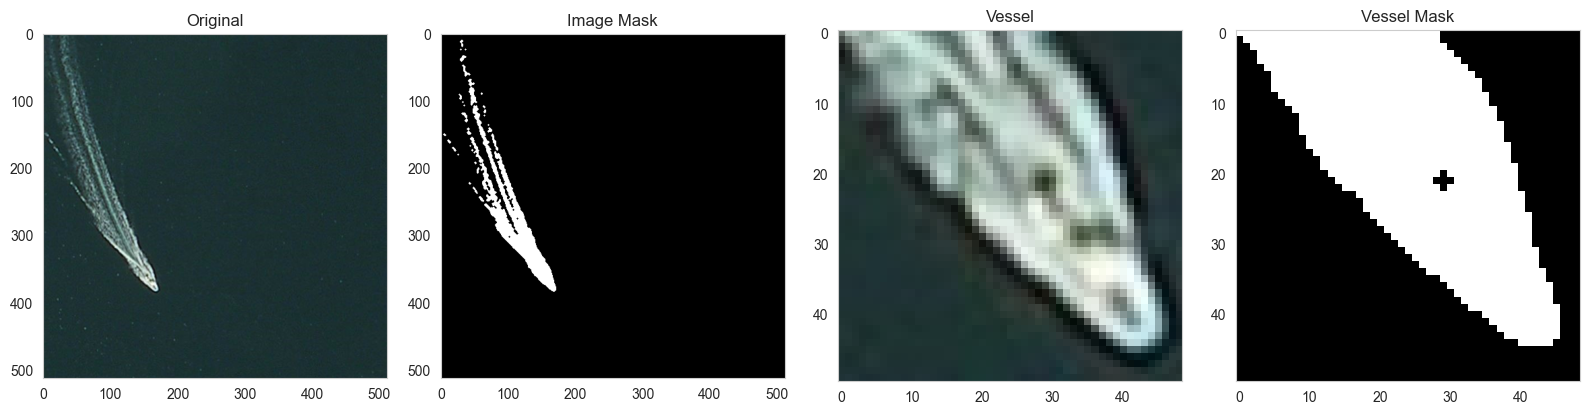

In [108]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mask = create_mask(img)

boat = cv2.imread(boat_path, cv2.IMREAD_COLOR)
obj = cv2.cvtColor(boat, cv2.COLOR_BGR2RGB)
boat_mask = create_mask(obj)

plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original')
plt.grid(False)

plt.subplot(1, 4, 2)
plt.imshow(img_mask, cmap='gray')
plt.title('Image Mask')
plt.grid(False)

plt.subplot(1, 4, 3)
plt.imshow(obj)
plt.title('Vessel')
plt.grid(False)

plt.subplot(1, 4, 4)
plt.imshow(boat_mask, cmap='gray')
plt.title('Vessel Mask')
plt.grid(False)

plt.tight_layout()
plt.show()

### Bad Boat Masking

In [88]:
img_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/masati-thesis/images/s0540.png"
boat_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/MasatiV2/MasatiV2Boats/s0540_boat0.png"

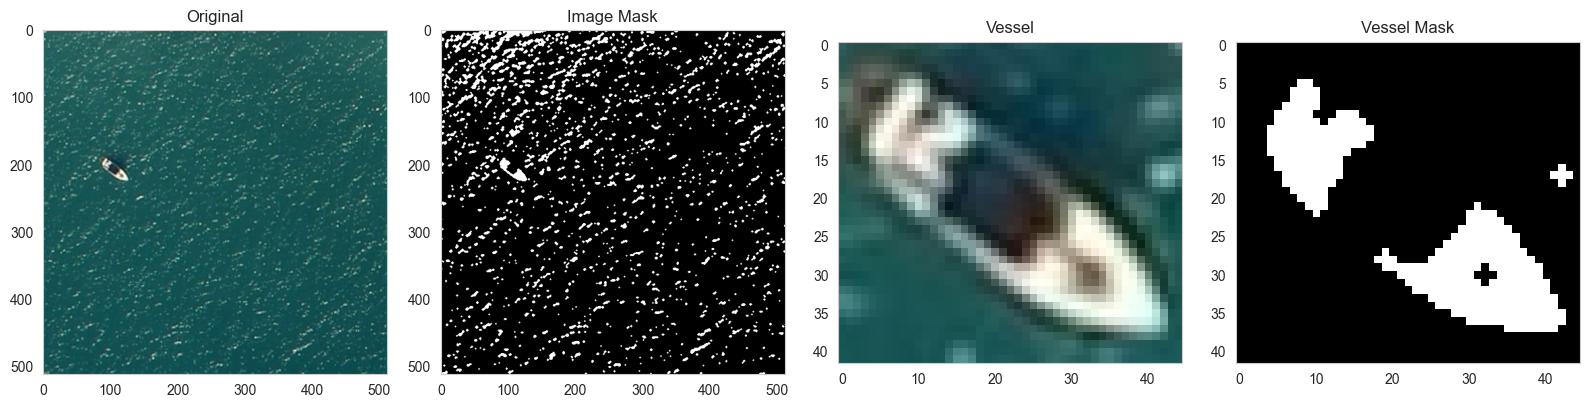

In [89]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mask = create_mask(img)

boat = cv2.imread(boat_path, cv2.IMREAD_COLOR)
obj = cv2.cvtColor(boat, cv2.COLOR_BGR2RGB)
boat_mask = create_mask(obj)

plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original')
plt.grid(False)

plt.subplot(1, 4, 2)
plt.imshow(img_mask, cmap='gray')
plt.title('Image Mask')
plt.grid(False)

plt.subplot(1, 4, 3)
plt.imshow(obj)
plt.title('Vessel')
plt.grid(False)

plt.subplot(1, 4, 4)
plt.imshow(boat_mask, cmap='gray')
plt.title('Vessel Mask')
plt.grid(False)

plt.tight_layout()
plt.show()

### Good Masking

In [93]:
img_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/masati-thesis/images/m0193.png"
boat_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/MasatiV2/MasatiV2Boats/m0193_boat4.png"

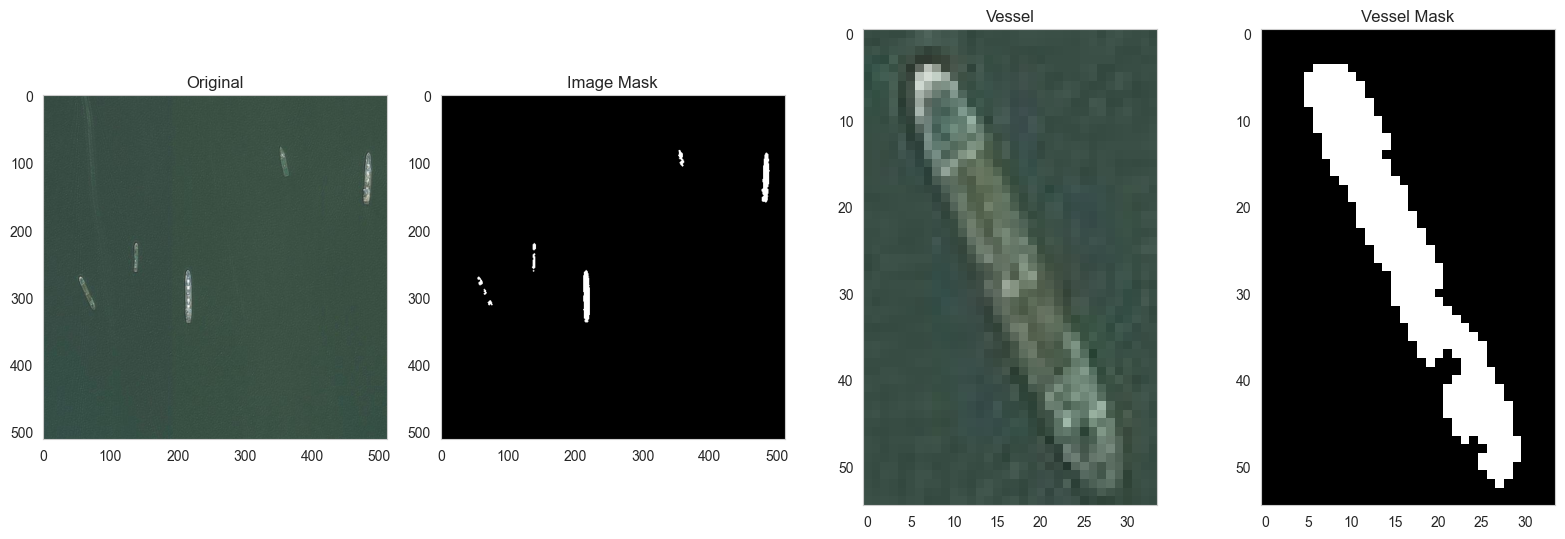

In [100]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mask = create_mask(img)

boat = cv2.imread(boat_path, cv2.IMREAD_COLOR)
obj = cv2.cvtColor(boat, cv2.COLOR_BGR2RGB)
boat_mask = create_mask(obj)

plt.figure(figsize=(16, 5.5))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original')
plt.grid(False)

plt.subplot(1, 4, 2)
plt.imshow(img_mask, cmap='gray')
plt.title('Image Mask')
plt.grid(False)

plt.subplot(1, 4, 3)
plt.imshow(obj)
plt.title('Vessel')
plt.grid(False)

plt.subplot(1, 4, 4)
plt.imshow(boat_mask, cmap='gray')
plt.title('Vessel Mask')
plt.grid(False)

plt.tight_layout()
plt.show()
